In [385]:
import math
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.stats import kstest, shapiro
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [386]:
def convert_to_float(value):        
    if "K" in value:
        return float(value[:-1]) * 1000
    if "M" in value:
        return float(value[:-1]) * 1000000
    if "B" in value:
        return float(value[:-1]) * 1000000000
    if "%" in value:
        return float(value[:-1]) / 100
    if value == "-":
        return None
    return float(value.replace(",", ""))

In [387]:
def test_normality(data):
    plt.figure(figsize=(6.40, 3.60), dpi=200)
    sb.distplot(data)
    plt.xticks(rotation=15)
    plt.show()
    ks_stat, ks_p = kstest(data, "norm")
    print("Kolmogorov-Smirnov Test Results: ")
    print("Test Statistics = ", ks_stat)
    print("P-value = ", ks_p)
    if ks_p > 0.05:
        print("Probably Gaussian.")
    else:
        print("Not Gausssian.")
    print("------------------------------------------------")
    sh_stat, sh_p = shapiro(data)
    print("Shapiro-Wilk Test Results: ")
    print("Test Statistics = ", sh_stat)
    print("P-value = ", sh_p)
    if sh_p > 0.05:
        print("Distribution Is Probably Gaussian.")
    else:
        print("Distribution Is Probably Not Gausssian.")    

In [388]:
def test_stationarity(data):
    print("Dicky Fuller Test Results:")
    results = adfuller(data, autolag="AIC")
    output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))
    print(output)
    if results[1] < 0.05:
        print("Data Is Stationary.")
    else:
        print("Data Is Not Stationary.")

In [389]:
def plot(data_label_pairs, x_label, y_label, title):
    plt.figure(figsize=(6.40, 3.60), dpi=200)
    for data, label in data_label_pairs:
        plt.plot(data, label=label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=15)
    plt.show()

In [390]:
def prepare_for_lstm(data, look_back):
    data_x, data_y = [], []
    for i in range(len(data) - look_back):
        data_window = data[i:i + look_back]
        data_x.append(data_window)
        data_y.append(data[i + look_back])
    return np.array(data_x), np.array(data_y)

In [391]:
def performance(actual, predicted):
    print("Performance:")
    mse = mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    r2 = r2_score(actual, predicted)
    print("mean squared error: ", mse)
    print("root mean square error: ", rmse)
    print("mean absolute error: ", mae)
    print("mean absolute percentage error: ", mape, "%")
    print("r^2: ", r2)

In [392]:
ether_data = pd.read_csv("Datasets/ETH-USD-Data.csv")
ether_data.rename(columns={"Price": "Close", "Vol.": "Volume", "Change %": "Change"}, inplace=True)
ether_data["Date"] = ether_data['Date'].astype("datetime64")
for column in ether_data.columns[1:]:
    ether_data[column] = ether_data[column].apply(convert_to_float)
ether_data = ether_data.reindex(columns=["Date", "Open", "High", "Low", "Close", "Volume", "Change"]).set_index("Date").sort_values("Date")
ether_data.interpolate(inplace=True)
dates = list(ether_data.index)

In [393]:
ether_data

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-03-10,11.20,11.85,11.07,11.75,0.0,0.0491
2016-03-11,11.75,11.95,11.75,11.95,180.0,0.0170
2016-03-12,11.95,13.45,11.95,12.92,830.0,0.0812
2016-03-13,12.92,15.07,12.92,15.07,1300.0,0.1664
2016-03-14,15.07,15.07,11.40,12.50,92180.0,-0.1705
...,...,...,...,...,...,...
2022-05-12,2087.17,2190.51,1796.24,1955.36,2840000.0,-0.0603
2022-05-13,1955.59,2146.22,1941.53,2009.53,1340000.0,0.0277
2022-05-14,2009.55,2068.66,1952.07,2056.30,656940.0,0.0233


In [394]:
ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2259 entries, 2016-03-10 to 2022-05-16
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2259 non-null   float64
 1   High    2259 non-null   float64
 2   Low     2259 non-null   float64
 3   Close   2259 non-null   float64
 4   Volume  2259 non-null   float64
 5   Change  2259 non-null   float64
dtypes: float64(6)
memory usage: 123.5 KB


In [395]:
ether_data.describe()

,Open,High,Low,Close,Volume,Change
count,2259.000000,2259.000000,2259.000000,2259.000000,2.259000e+03,2259.000000
mean,816.945573,845.670832,783.999934,817.810164,1.319516e+07,0.003885
std,1163.714564,1200.428925,1120.644492,1163.846004,1.035528e+08,0.056125
min,6.680000,7.320000,5.860000,6.700000,0.000000e+00,-0.445500
25%,135.530000,139.740000,130.825000,135.625000,5.344550e+05,-0.022300
50%,259.920000,269.770000,245.750000,261.540000,1.480000e+06,0.001100
75%,784.640000,830.525000,736.040000,786.085000,7.930000e+06,0.029450
max,4808.340000,4864.060000,4715.430000,4808.380000,1.790000e+09,0.295100


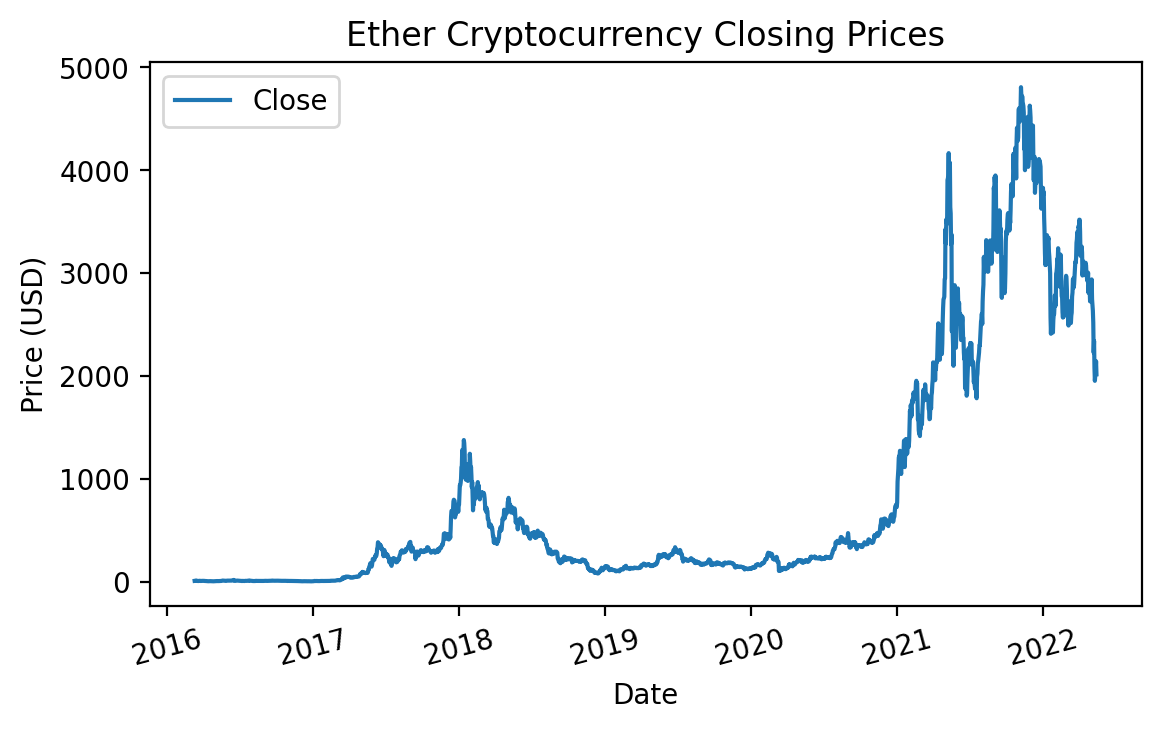

In [396]:
plot(data_label_pairs=[(ether_data["Close"], "Close")], x_label="Date", y_label="Price (USD)", title="Ether Cryptocurrency Closing Prices")

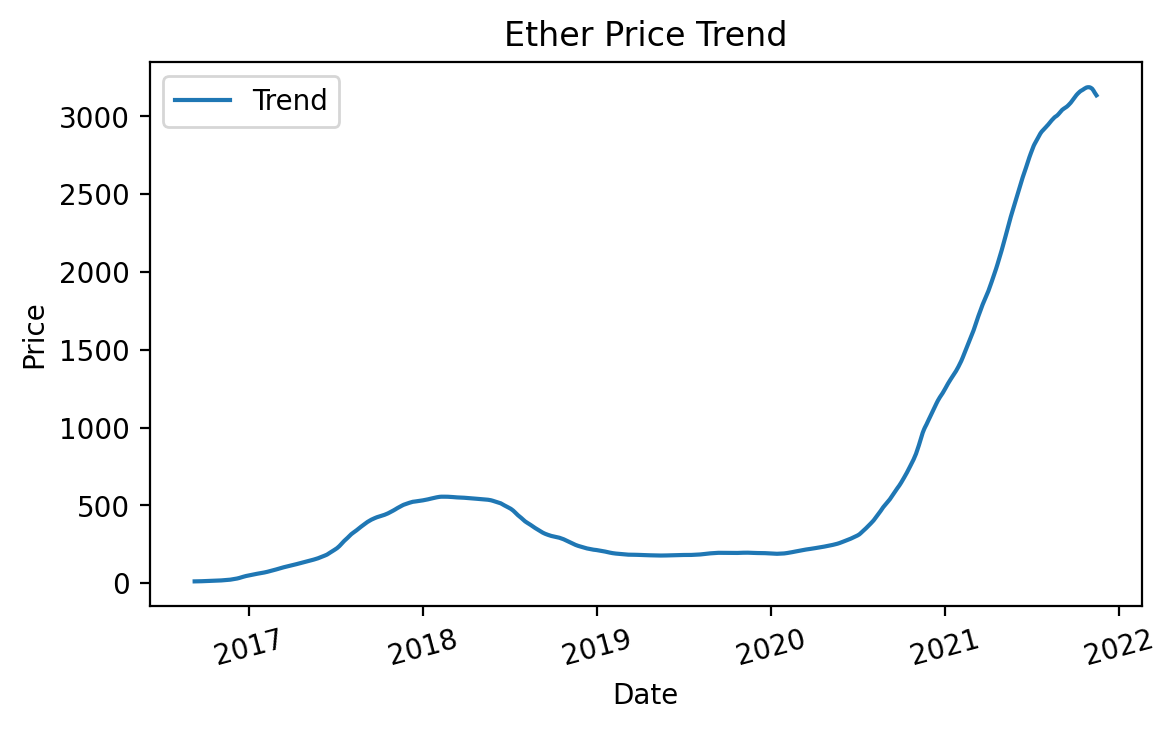

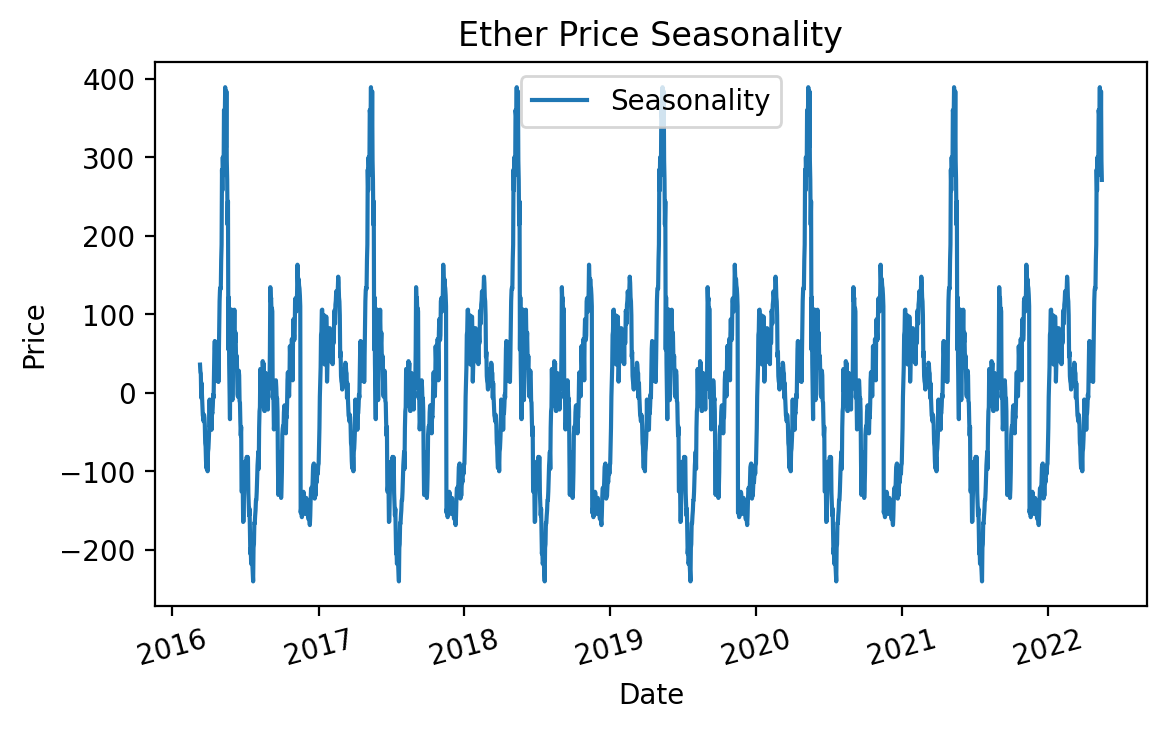

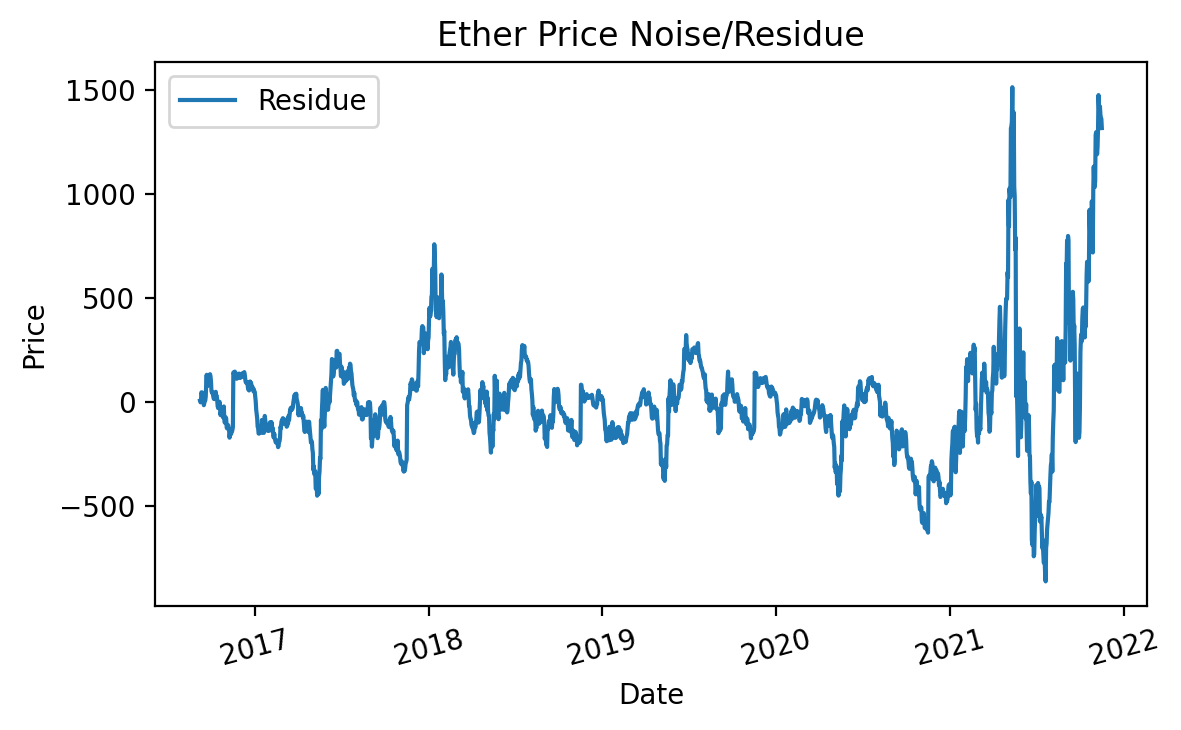

In [397]:
decomposition = seasonal_decompose(ether_data["Close"], model="additive", period=365)
plot([(decomposition.trend, "Trend")], "Date", "Price", "Ether Price Trend")
plot([(decomposition.seasonal, "Seasonality")], "Date", "Price", "Ether Price Seasonality")
plot([(decomposition.resid, "Residue")], "Date", "Price", "Ether Price Noise/Residue")

In [398]:
test_stationarity(ether_data["Close"])

Dicky Fuller Test Results:
Statistics                -1.177267
p-value                    0.683298
Lags                      17.000000
Observations            2241.000000
Critical Value (1%)       -3.433271
Critical Value (5%)       -2.862831
Critical Value (10%)      -2.567457
dtype: float64
Data Is Not Stationary.


C:\Users\samee\AppData\Local\Temp\ipykernel_5416\2946238253.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))


c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


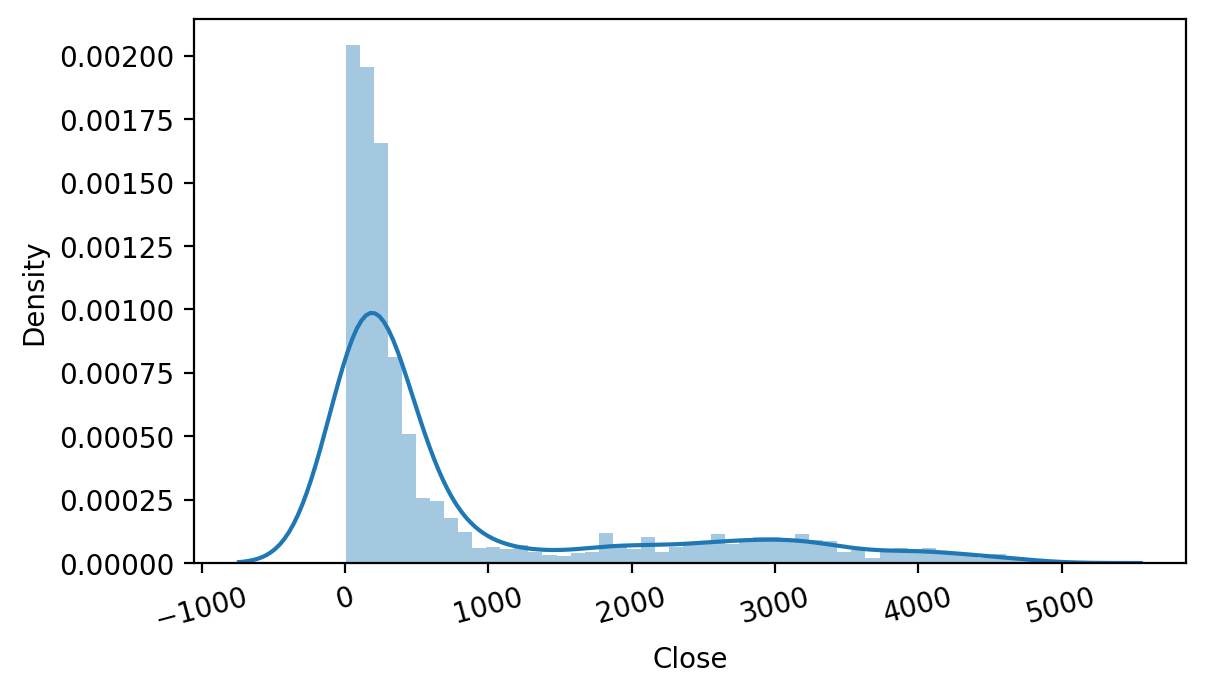

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.999999999989579
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6872783303260803
P-value =  0.0
Distribution Is Probably Not Gausssian.


In [399]:
test_normality(ether_data['Close'])

In [400]:
ether_data_uni = pd.DataFrame(ether_data["Close"], columns=["Close"])

In [401]:
ether_data_uni

,Close
Date,
2016-03-10,11.75
2016-03-11,11.95
2016-03-12,12.92
2016-03-13,15.07
2016-03-14,12.50
...,...
2022-05-12,1955.36
2022-05-13,2009.53
2022-05-14,2056.30


In [402]:
ether_data_uni.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2259 entries, 2016-03-10 to 2022-05-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2259 non-null   float64
dtypes: float64(1)
memory usage: 35.3 KB


In [403]:
ether_data_uni.describe()

,Close
count,2259.000000
mean,817.810164
std,1163.846004
min,6.700000
25%,135.625000
50%,261.540000
75%,786.085000
max,4808.380000


In [404]:
uni_training_size = int(len(ether_data_uni) * 0.70)
uni_validation_size = int(len(ether_data_uni) * 0.10)
uni_test_size = len(ether_data_uni) - uni_training_size - uni_validation_size
train_ether_uni = ether_data_uni[:uni_training_size]
validation_ether_uni = ether_data_uni[uni_training_size:uni_training_size + uni_validation_size]
test_ether_uni = ether_data_uni[uni_training_size + uni_validation_size:]

In [405]:
train_ether_uni

,Close
Date,
2016-03-10,11.75
2016-03-11,11.95
2016-03-12,12.92
2016-03-13,15.07
2016-03-14,12.50
...,...
2020-07-03,225.12
2020-07-04,229.15
2020-07-05,227.98


In [406]:
validation_ether_uni

,Close
Date,
2020-07-08,246.99
2020-07-09,242.02
2020-07-10,241.26
2020-07-11,239.20
2020-07-12,242.75
...,...
2021-02-13,1815.49
2021-02-14,1801.78
2021-02-15,1778.82


In [407]:
test_ether_uni

,Close
Date,
2021-02-18,1934.16
2021-02-19,1955.59
2021-02-20,1913.88
2021-02-21,1933.45
2021-02-22,1777.28
...,...
2022-05-12,1955.36
2022-05-13,2009.53
2022-05-14,2056.30


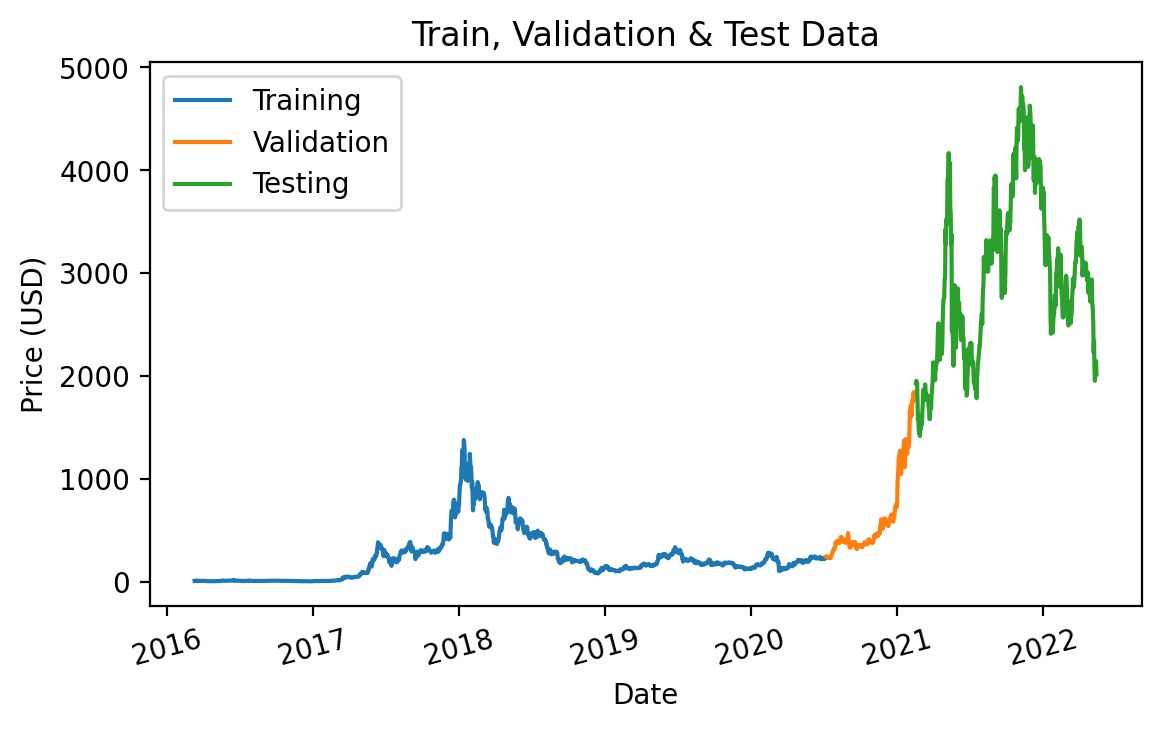

In [408]:
plot([(train_ether_uni, "Training"), (validation_ether_uni, "Validation"), (test_ether_uni, "Testing")], "Date", "Price (USD)", "Train, Validation & Test Data")

In [409]:
standard_scaler = StandardScaler()
scaled_train_uni = standard_scaler.fit_transform(train_ether_uni)
scaled_validation_uni = standard_scaler.fit_transform(validation_ether_uni)
scaled_test_uni = standard_scaler.fit_transform(test_ether_uni)

In [410]:
scaled_train_uni.shape

(1581, 1)

In [411]:
scaled_validation_uni.shape

(225, 1)

In [412]:
scaled_test_uni.shape

(453, 1)

In [413]:
uni_train_x, uni_train_y = prepare_for_lstm(scaled_train_uni, 7)
uni_validation_x, uni_validation_y = prepare_for_lstm(scaled_validation_uni, 7)
uni_test_x, uni_test_y = prepare_for_lstm(scaled_test_uni, 7)
uni_train_x = uni_train_x.reshape((-1, uni_train_x.shape[1], 1))
uni_validation_x = uni_validation_x.reshape(-1, uni_validation_x.shape[1], 1)
uni_test_x = uni_test_x.reshape((-1, uni_test_x.shape[1], 1))

In [414]:
inversed_actual = standard_scaler.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
actual_uni = pd.DataFrame(data=inversed_actual, index=dates[-1 * len(inversed_actual):], columns=["Close"])
actual_uni.index.name = "Date"

In [415]:
uni_train_x.shape, uni_train_y.shape

((1574, 7, 1), (1574, 1))

In [416]:
uni_test_x.shape, uni_test_y.shape

((446, 7, 1), (446, 1))

In [417]:
actual_uni

,Close
Date,
2021-02-25,1476.15
2021-02-26,1445.44
2021-02-27,1458.93
2021-02-28,1418.76
2021-03-01,1570.03
...,...
2022-05-12,1955.36
2022-05-13,2009.53
2022-05-14,2056.30


In [418]:
vanilla_model = tf.keras.models.Sequential()
vanilla_model.add(tf.keras.layers.LSTM(units=64, activation="relu", input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
vanilla_model.add(tf.keras.layers.Dropout(0.25))
vanilla_model.add(tf.keras.layers.Dense(units=1))
vanilla_model.summary()
vanilla_model.compile(optimizer="adam", loss="mse")
vanilla_results = vanilla_model.fit(uni_train_x, uni_train_y, batch_size=64, epochs=100, verbose=1, validation_data=(uni_validation_x, uni_validation_y))

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 2s 15ms/step - loss: 0.8008 - val_loss: 0.5455
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 0.2489 - val_loss: 0.0746
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 0.1267 - val_loss: 0.1446
Epoch 4/100
25/

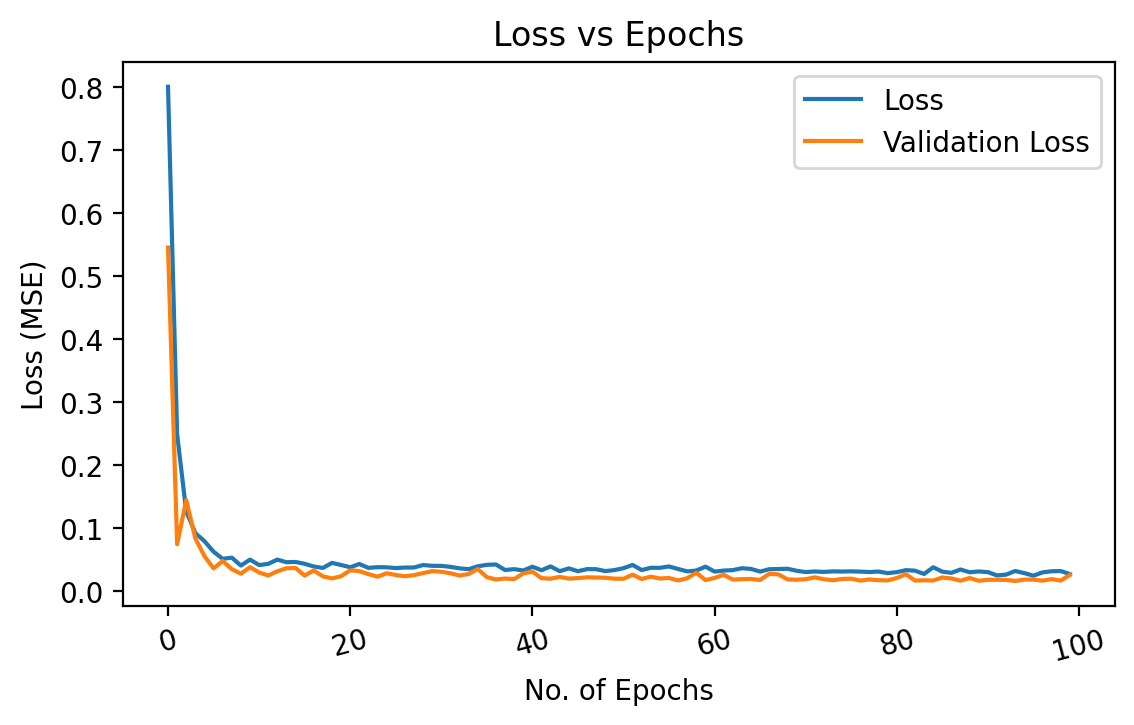

In [419]:
plot(data_label_pairs=[(vanilla_results.history["loss"], "Loss"), (vanilla_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [420]:
vanilla_scaled_predicted = vanilla_model.predict(uni_test_x)
predicted_vanilla =  pd.DataFrame(data=standard_scaler.inverse_transform(vanilla_scaled_predicted), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_vanilla.index.name = "Date"

In [421]:
predicted_vanilla

,Predicted_Close
Date,
2021-02-25,1662.863281
2021-02-26,1543.482178
2021-02-27,1438.248169
2021-02-28,1364.227539
2021-03-01,1286.226196
...,...
2022-05-12,2359.315674
2022-05-13,2227.887451
2022-05-14,2148.569580


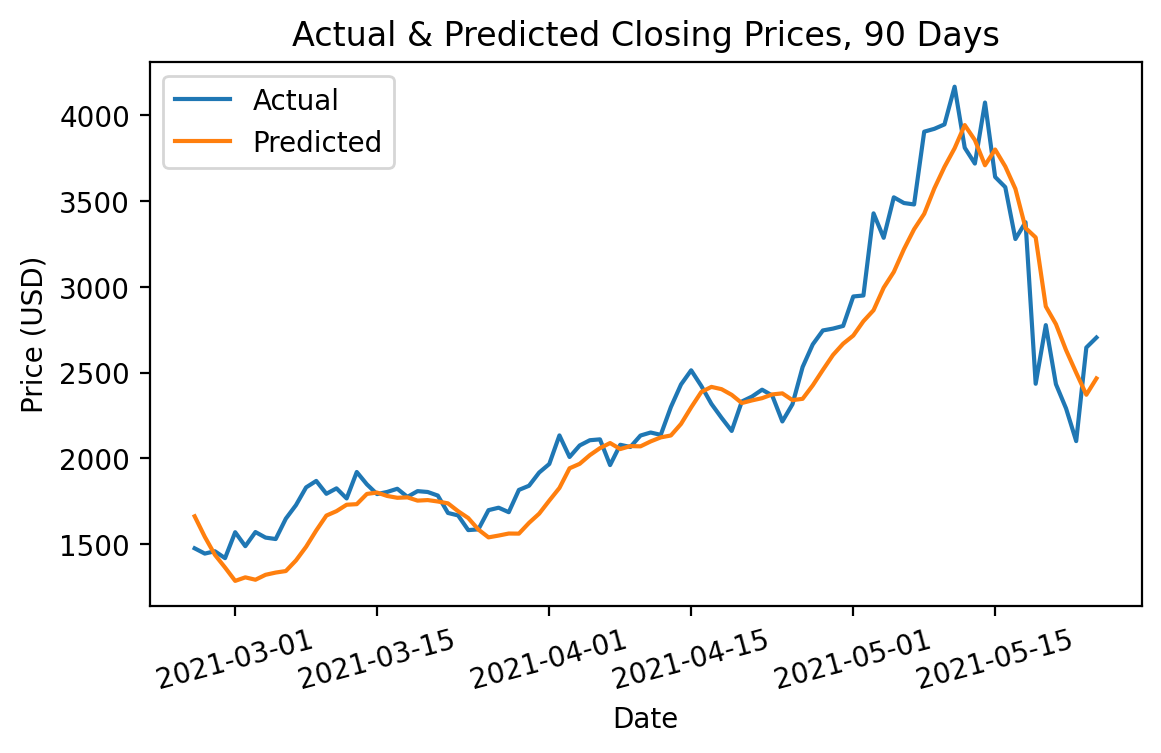

In [422]:
plot(data_label_pairs=[(actual_uni["Close"][:90], "Actual"), (predicted_vanilla["Predicted_Close"][:90], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual & Predicted Closing Prices, 90 Days")

In [423]:
performance(actual_uni["Close"][:90], predicted_vanilla["Predicted_Close"][:90])

Performance:
mean squared error:  50329.99646939517
root mean square error:  224.34347877617296
mean absolute error:  173.36972037760415
mean absolute percentage error:  7.484114659319251 %
r^2:  0.9039774861844194


In [424]:
stacked_model = tf.keras.models.Sequential()
stacked_model.add(tf.keras.layers.LSTM(units=64, activation="relu", return_sequences=True,  input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
stacked_model.add(tf.keras.layers.Dropout(0.25))
stacked_model.add(tf.keras.layers.LSTM(units=64))
stacked_model.add(tf.keras.layers.Dropout(0.25))
stacked_model.add(tf.keras.layers.Dense(units=1))
stacked_model.summary()
stacked_model.compile(optimizer="adam", loss="mse")
stacked_results = stacked_model.fit(uni_train_x, uni_train_y, batch_size=64, epochs=100, verbose=1, validation_data=(uni_validation_x, uni_validation_y))

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 7, 64)             16896     
                                                                 
 dropout_23 (Dropout)        (None, 7, 64)             0         
                                                                 
 lstm_41 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================

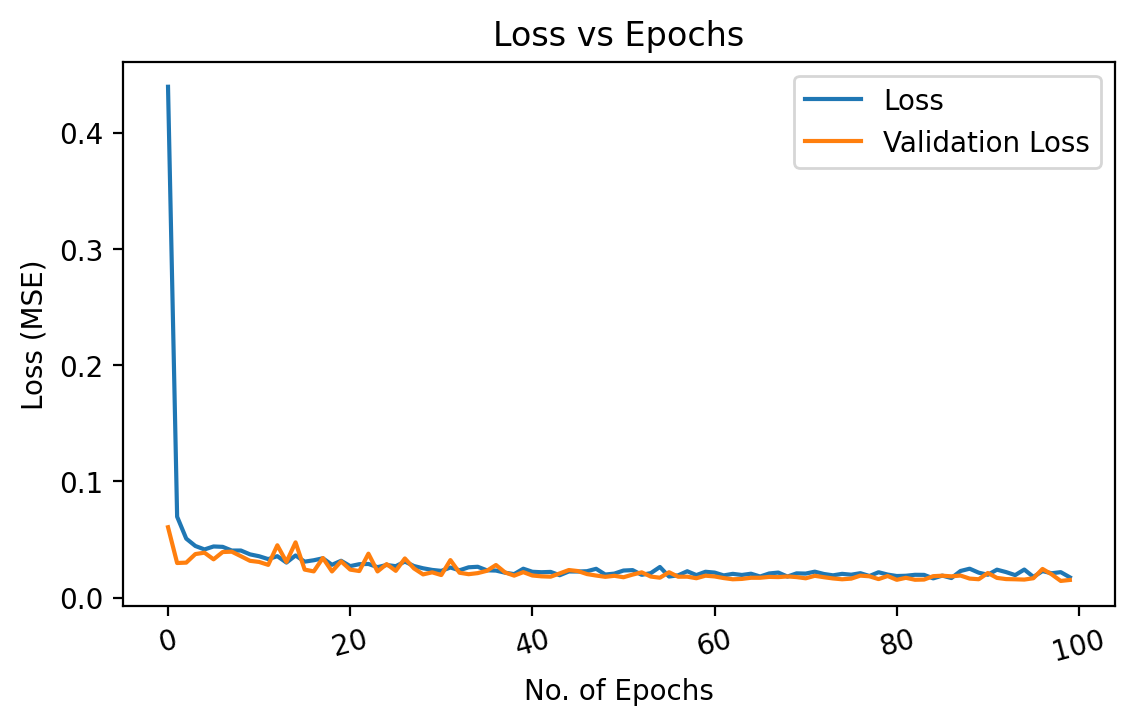

In [425]:
plot(data_label_pairs=[(stacked_results.history["loss"], "Loss"), (stacked_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [426]:
predicted_stacked =  pd.DataFrame(data=standard_scaler.inverse_transform(stacked_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_stacked.index.name = "Date"

In [427]:
predicted_stacked

,Predicted_Close
Date,
2021-02-25,2028.793579
2021-02-26,2025.932983
2021-02-27,2020.163452
2021-02-28,2010.672729
2021-03-01,2003.586670
...,...
2022-05-12,2404.344482
2022-05-13,2312.153809
2022-05-14,2229.672119


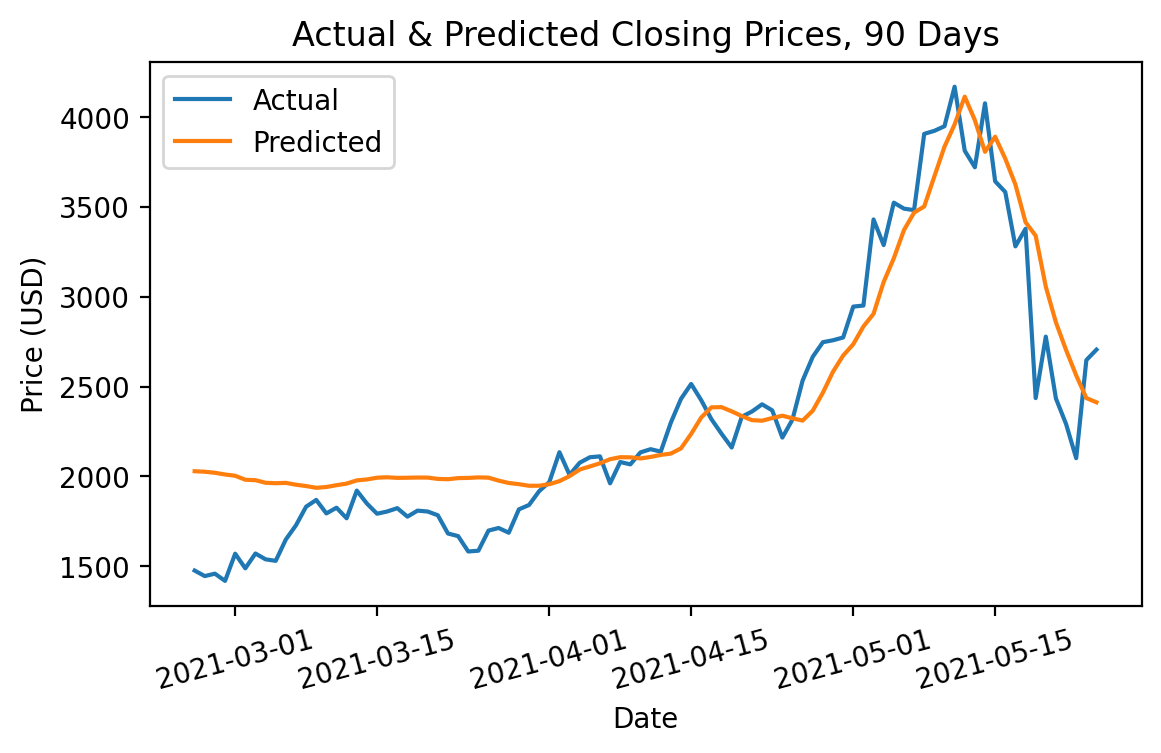

In [428]:
plot(data_label_pairs=[(actual_uni["Close"][:90], "Actual"), (predicted_stacked["Predicted_Close"][:90], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual & Predicted Closing Prices, 90 Days")

In [429]:
performance(actual_uni["Close"][:90], predicted_stacked["Predicted_Close"][:90])

Performance:
mean squared error:  77703.65104936896
root mean square error:  278.75374625172117
mean absolute error:  223.33075135633683
mean absolute percentage error:  10.893395538308187 %
r^2:  0.8517524253961317


In [430]:
bidirectional_model = tf.keras.models.Sequential()
bidirectional_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, activation="relu"), input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
bidirectional_model.add(tf.keras.layers.Dropout(0.25))
bidirectional_model.add(tf.keras.layers.Dense(units=1))
bidirectional_model.summary()
bidirectional_model.compile(optimizer="adam", loss="mse")
bidirectional_results = bidirectional_model.fit(uni_train_x, uni_train_y, batch_size=64, epochs=100, verbose=1, validation_data=(uni_validation_x, uni_validation_y))

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 128)              33792     
 nal)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 129       
                                                                 
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 3s 27ms/step - loss: 0.5157 - val_loss: 0.1155
Epoch 2/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0743 - val_loss: 0.0773
Epoch 3/100
25/25 [============================

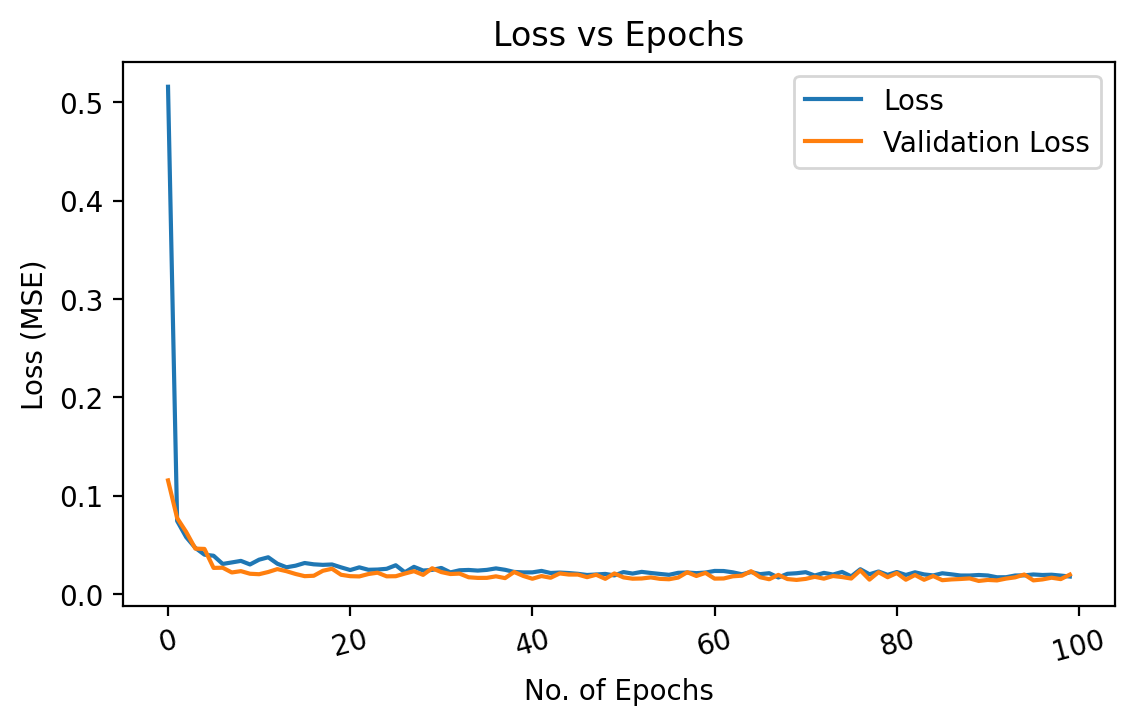

In [431]:
plot(data_label_pairs=[(bidirectional_results.history["loss"], "Loss"), (bidirectional_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [432]:
predicted_bidirectional =  pd.DataFrame(data=standard_scaler.inverse_transform(bidirectional_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_bidirectional.index.name = "Date"

In [433]:
predicted_bidirectional

,Predicted_Close
Date,
2021-02-25,1656.537842
2021-02-26,1538.075073
2021-02-27,1432.300049
2021-02-28,1362.885010
2021-03-01,1302.903564
...,...
2022-05-12,2355.636230
2022-05-13,2225.201172
2022-05-14,2144.455811


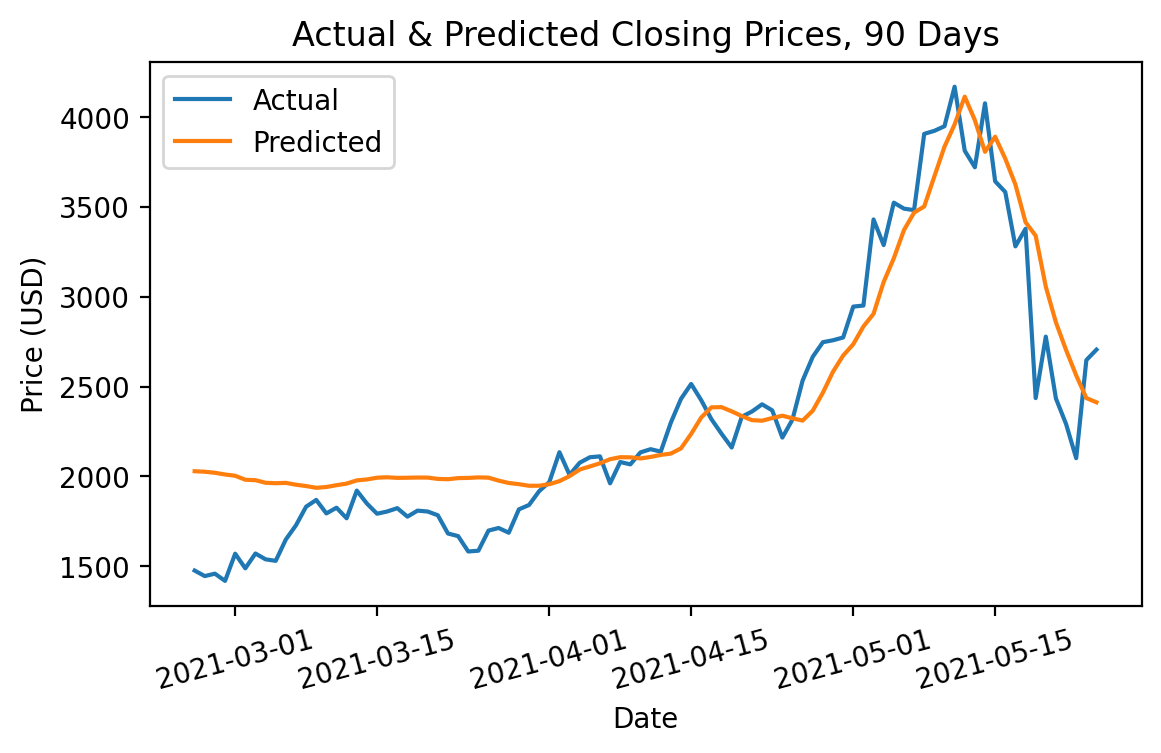

In [434]:
plot(data_label_pairs=[(actual_uni["Close"][:90], "Actual"), (predicted_stacked["Predicted_Close"][:90], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual & Predicted Closing Prices, 90 Days")

In [435]:
performance(actual_uni["Close"][:90], predicted_bidirectional["Predicted_Close"][:90])

Performance:
mean squared error:  41760.47585951457
root mean square error:  204.3538006975025
mean absolute error:  151.84975824652776
mean absolute percentage error:  6.531193395217969 %
r^2:  0.920326919303405


In [436]:
ether_data.corr()

,Open,High,Low,Close,Volume,Change
Open,1.000000,0.999369,0.998546,0.998210,0.103999,-0.034983
High,0.999369,1.000000,0.998455,0.999129,0.104238,-0.019005
Low,0.998546,0.998455,1.000000,0.999118,0.105847,-0.013904
Close,0.998210,0.999129,0.999118,1.000000,0.104690,-0.001398
Volume,0.103999,0.104238,0.105847,0.104690,1.000000,0.000385
Change,-0.034983,-0.019005,-0.013904,-0.001398,0.000385,1.000000


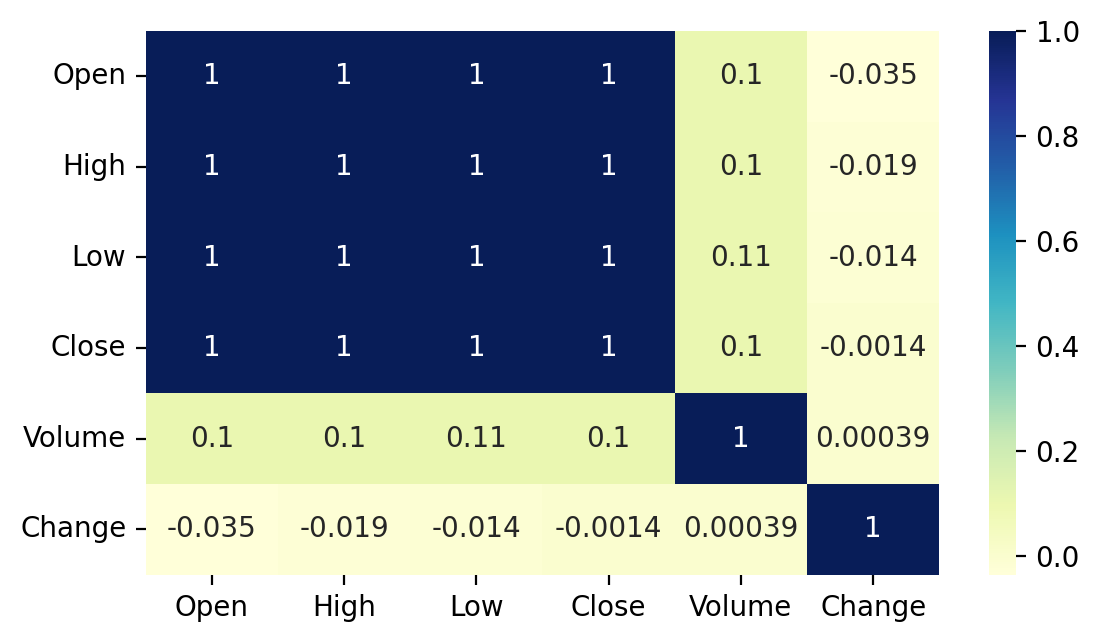

In [437]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
sb.heatmap(ether_data.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [438]:
ether_data_multi = pd.DataFrame(ether_data, columns=["Open", "High", "Low", "Close"])

In [439]:
ether_data_multi

,Open,High,Low,Close
Date,,,,
2016-03-10,11.20,11.85,11.07,11.75
2016-03-11,11.75,11.95,11.75,11.95
2016-03-12,11.95,13.45,11.95,12.92
2016-03-13,12.92,15.07,12.92,15.07
2016-03-14,15.07,15.07,11.40,12.50
...,...,...,...,...
2022-05-12,2087.17,2190.51,1796.24,1955.36
2022-05-13,1955.59,2146.22,1941.53,2009.53
2022-05-14,2009.55,2068.66,1952.07,2056.30


In [440]:
ether_data_multi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2259 entries, 2016-03-10 to 2022-05-16
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2259 non-null   float64
 1   High    2259 non-null   float64
 2   Low     2259 non-null   float64
 3   Close   2259 non-null   float64
dtypes: float64(4)
memory usage: 88.2 KB


In [441]:
ether_data_multi.describe()

,Open,High,Low,Close
count,2259.000000,2259.000000,2259.000000,2259.000000
mean,816.945573,845.670832,783.999934,817.810164
std,1163.714564,1200.428925,1120.644492,1163.846004
min,6.680000,7.320000,5.860000,6.700000
25%,135.530000,139.740000,130.825000,135.625000
50%,259.920000,269.770000,245.750000,261.540000
75%,784.640000,830.525000,736.040000,786.085000
max,4808.340000,4864.060000,4715.430000,4808.380000


In [442]:
multi_training_size = int(len(ether_data_multi) * 0.70)
multi_validation_size = int(len(ether_data_multi) * 0.10)
multi_test_size = len(ether_data_multi) - multi_training_size - multi_validation_size
train_ether_multi = ether_data_multi[:multi_training_size]
validation_ether_multi = ether_data_multi[multi_training_size:multi_training_size + multi_validation_size]
test_ether_multi = ether_data_multi[multi_training_size + multi_validation_size:]

In [443]:
train_ether_multi

,Open,High,Low,Close
Date,,,,
2016-03-10,11.20,11.85,11.07,11.75
2016-03-11,11.75,11.95,11.75,11.95
2016-03-12,11.95,13.45,11.95,12.92
2016-03-13,12.92,15.07,12.92,15.07
2016-03-14,15.07,15.07,11.40,12.50
...,...,...,...,...
2020-07-03,226.42,228.14,224.77,225.12
2020-07-04,225.09,230.40,224.80,229.15
2020-07-05,229.09,229.80,223.79,227.98


In [444]:
validation_ether_multi

,Open,High,Low,Close
Date,,,,
2020-07-08,239.26,248.76,238.00,246.99
2020-07-09,246.93,247.63,238.28,242.02
2020-07-10,242.01,242.17,236.19,241.26
2020-07-11,241.21,241.64,237.76,239.20
2020-07-12,239.20,243.79,236.91,242.75
...,...,...,...,...
2021-02-13,1840.90,1871.36,1766.05,1815.49
2021-02-14,1815.44,1850.00,1787.11,1801.78
2021-02-15,1800.60,1835.51,1661.09,1778.82


In [445]:
test_ether_multi

,Open,High,Low,Close
Date,,,,
2021-02-18,1849.95,1950.04,1849.05,1934.16
2021-02-19,1934.17,1968.93,1892.70,1955.59
2021-02-20,1955.54,2040.79,1800.00,1913.88
2021-02-21,1912.97,1974.99,1885.70,1933.45
2021-02-22,1933.52,1935.04,1561.68,1777.28
...,...,...,...,...
2022-05-12,2087.17,2190.51,1796.24,1955.36
2022-05-13,1955.59,2146.22,1941.53,2009.53
2022-05-14,2009.55,2068.66,1952.07,2056.30


In [446]:
standard_scaler_multi = StandardScaler()
scaled_train_multi = standard_scaler_multi.fit_transform(train_ether_multi)
scaled_validation_multi = standard_scaler_multi.fit_transform(validation_ether_multi)
scaled_test_multi = standard_scaler_multi.fit_transform(test_ether_multi)

In [447]:
scaled_train_multi.shape

(1581, 4)

In [448]:
scaled_validation_multi.shape

(225, 4)

In [449]:
scaled_test_multi.shape

(453, 4)

In [450]:
multi_train_x, multi_train_y = prepare_for_lstm(scaled_train_multi, 7)
multi_validation_x, multi_validation_y = prepare_for_lstm(scaled_validation_multi, 7)
multi_test_x, multi_test_y = prepare_for_lstm(scaled_test_multi, 7)

In [451]:
multi_train_x.shape, multi_train_y.shape

((1574, 7, 4), (1574, 4))

In [452]:
multi_validation_x.shape, multi_validation_y.shape

((218, 7, 4), (218, 4))

In [453]:
multi_test_x.shape, multi_test_y.shape

((446, 7, 4), (446, 4))

In [454]:
inversed_actual_multi = standard_scaler_multi.inverse_transform(multi_test_y)
actual_multi = pd.DataFrame(data=inversed_actual_multi, index=dates[-1 * len(inversed_actual_multi):], columns=["Open", "High", "Low", "Close"])
actual_multi.index.name = "Date"

In [455]:
actual_multi

,Open,High,Low,Close
Date,,,,
2021-02-25,1623.76,1669.24,1460.92,1476.15
2021-02-26,1476.77,1561.66,1403.30,1445.44
2021-02-27,1445.69,1527.69,1427.15,1458.93
2021-02-28,1458.84,1467.76,1294.79,1418.76
2021-03-01,1418.91,1571.15,1411.55,1570.03
...,...,...,...,...
2022-05-12,2087.17,2190.51,1796.24,1955.36
2022-05-13,1955.59,2146.22,1941.53,2009.53
2022-05-14,2009.55,2068.66,1952.07,2056.30


In [456]:
multi_model = tf.keras.models.Sequential()
multi_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, activation="relu", return_sequences=True), input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.25))
multi_model.add(tf.keras.layers.LSTM(units=64, input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.25))
multi_model.add(tf.keras.layers.Dense(units=multi_train_x.shape[2]))
multi_model.summary()
multi_model.compile(optimizer="adam", loss="mse")
multi_results = multi_model.fit(multi_train_x, multi_train_y, batch_size=64, epochs=100, verbose=1, validation_data=(multi_validation_x, multi_validation_y))

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 7, 128)           35328     
 nal)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 7, 128)            0         
                                                                 
 lstm_44 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 4)                 260       
                                                                 
Total params: 84,996
Trainable params: 84,996
Non-trainable params: 0
_________________________________________________

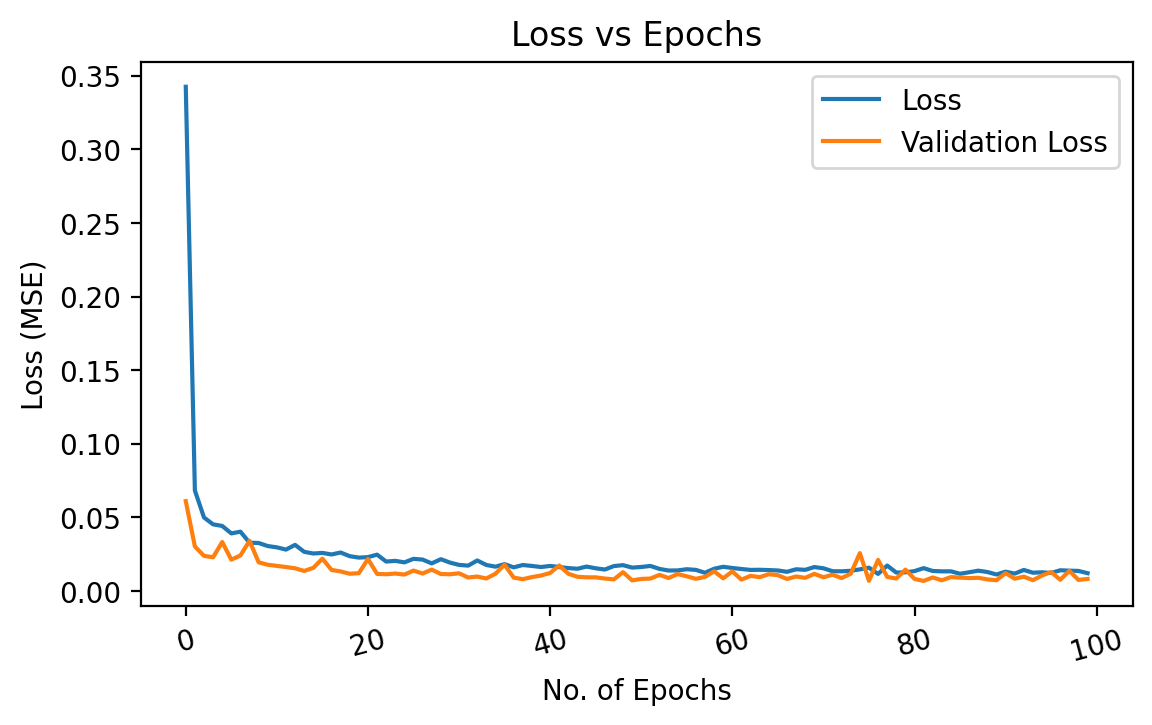

In [457]:
plot(data_label_pairs=[(multi_results.history["loss"], "Loss"), (multi_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [458]:
predicted_multi =  pd.DataFrame(data=standard_scaler_multi.inverse_transform(multi_model.predict(multi_test_x)), index=dates[-1 * len(inversed_actual_multi):], columns=["Predicted_Open", "Predicted_High", "Predicted_Low", "Predicted_Close"])
predicted_multi.index.name = "Date"

In [459]:
predicted_multi

,Predicted_Open,Predicted_High,Predicted_Low,Predicted_Close
Date,,,,
2021-02-25,1918.842529,2012.773438,1819.554199,1920.410400
2021-02-26,1898.209351,1991.915649,1799.645264,1899.470337
2021-02-27,1878.144043,1971.217896,1779.347656,1878.900635
2021-02-28,1866.143311,1958.134033,1767.066895,1866.129639
2021-03-01,1857.363770,1948.745605,1758.942261,1856.848267
...,...,...,...,...
2022-05-12,2276.434570,2382.851074,2165.114502,2285.763428
2022-05-13,2176.444336,2283.217041,2066.020264,2186.083740
2022-05-14,2125.089844,2230.728271,2013.838013,2134.509277


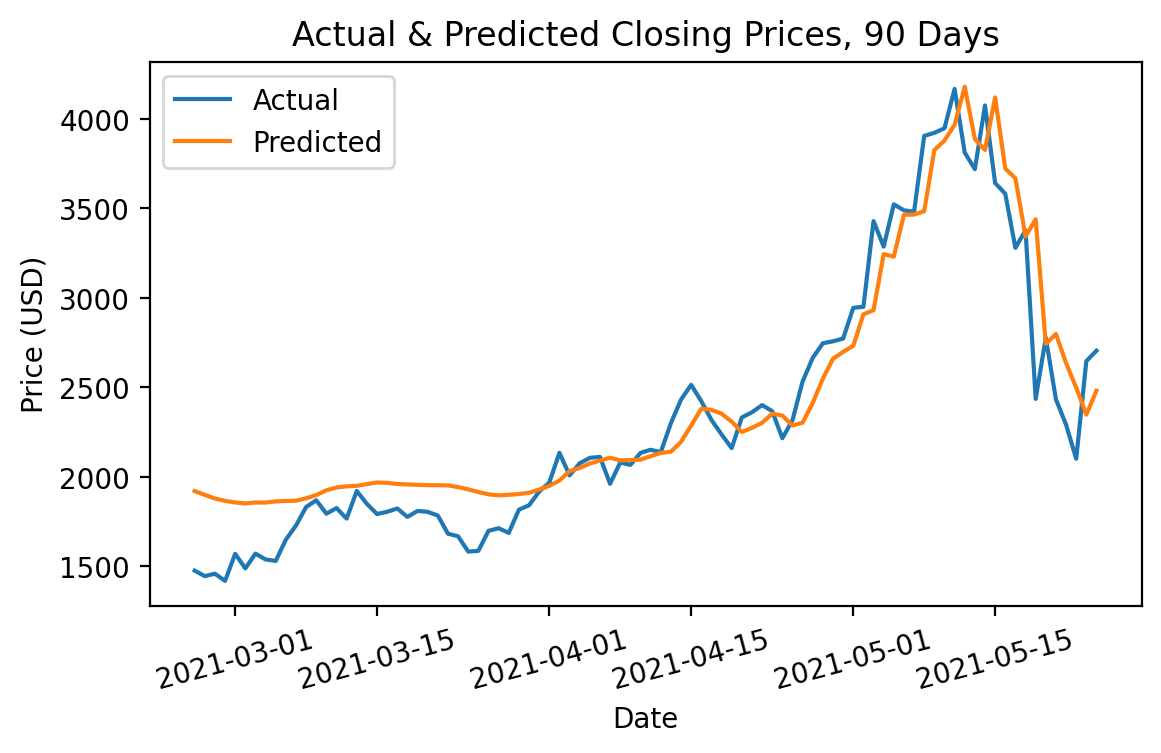

In [460]:
plot(data_label_pairs=[(actual_multi["Close"][:90], "Actual"), (predicted_multi["Predicted_Close"][:90], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual & Predicted Closing Prices, 90 Days")

In [461]:
performance(actual_multi["Close"][:90], predicted_multi["Predicted_Close"][:90])

Performance:
mean squared error:  59559.39698332463
root mean square error:  244.0479399284588
mean absolute error:  185.3543732096354
mean absolute percentage error:  8.860468081914355 %
r^2:  0.8863690955520612
